### Long short term memory (LSTM) Neural Networks

- Cell state : Represents the long term memory, ther are not any weights and/or biases to modify it directly thus avoiding the<br>
exploding/vanishing gradient problem.

- Hidden state : Represents the shor term memory

#### First stage
##### Inputs
- Previous long term memory =  $L_{t1}$            
- Previous short term memormy = $S_{t1}$
- First input = $x_1$

##### Weights
- Long term memory weight = $w_{l1}$
- Short term memory weight = $w_{s1}$
- Input weight = $w_1$

##### Activation function
- $Sigmoid$

$z_{\_first} = (x_1\,*\,w_1) + (S_{t1}\,*\,w_{s1}) + b_1$<br>
$y_{\_first} = \sigma(z_{\_first})$<br>
Percentage of the previous Long-term memory preserved = $y_1 * L_{t1}$

Since the activation function used is the sigmoid function which outputs a number between 0-1, in this first stage what it is being determined is the<br>
percentage of the Long-term memory that will be remembered, this first stage of the lstm is also known as the $Forget gate$.


#### Second Stage
The second stage consists of three parts: 

- First part: the short-term memory is combined with the input to create a potential long term memory.
  ##### Activation function
- $Tan-h$<br>

$z_{2-1} = (x_1\,*\,w_{2-1}) + (S_{t1}\,*\,w_{s2-1}) + b_{2-1}$<br>
$y_{2-1} = \sigma(z_{2-1})$<br>



- Second part: the input is used to comupte the percentage of the potential long term memory is preserved.
##### Activation function
- $Sigmoid$


$z_{2-2} = (x_1\,*\,w_{2-2}) + (S_{t1}\,*\,w_{s2-2}) + b_{2-2}$<br>
$y_{2-2} = \sigma(z_{2-2})$<br>


- Third part: In this step the potential long term memory is multiplied by the percentage and subsequently added to the long term memory generating a new long term memory.<br>

$L_{t2} = (y_{2-1} *  y_{2-2}) +  (y_1 * L_{t1})$

The entire process above which encompasses the firs and second state is denominated the $$Input\:Gate$$

#### Third stage

In this stage we take the new long term memory and pass it through a tan-h function to generate a short term memory, aftewards we calculate what percentage of it will be preserved.

- Part 1 generating the new short term memory
 ##### Activation function
- $Tan-h$<br>

$z_{3-1} = L_{t2}$<br>
$y_{3-1} = \sigma(z_{3-1})$<br>

- Part 2 determining percentage preserved<br>
$z_{3-2} = (x_1\,*\,w_{3-2}) + (S_{t1}\,*\,w_{s3-2}) + b_{2-2}$<br>
$y_{3-2} = \sigma(z_{3-2})$<br>

- Part 3 Generating new short term memory<br>

$S_{t2} = y_{3-1} * \:y_{3-2}$

The third stage generates the output of the lstm thus this step is called the $Output\: Gate$

### Dependencies

In [2]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D

import os
import string
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import imdb # new! 
from tensorflow.keras.preprocessing.sequence import pad_sequences #new!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Activation,BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding # new!
from tensorflow.keras.callbacks import ModelCheckpoint # new! 

from tensorflow.keras.layers import SimpleRNN # new! 
from tensorflow.keras.layers import LSTM # new! 

from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay 

#### Loading Data
For a given data set: 

* The TensorFlow Keras module's text utilities [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text) quickly preprocess natural language and convert it into an index
* The `Tokenizer` class covered therein may do everything you need in a single line of code:
    * tokenize into words or characters
    * `num_words`: maximum unique tokens
    * filter out punctuation
    * lower case
    * convert words to an integer index
* Other natural language preprocessing steps you may want to consider for your particular dataset and application are covered in the [*Natural Language Preprocessing* notebook](https://github.com/jonkrohn/DLTFpT/blob/master/notebooks/natural_language_preprocessing.ipynb), including: 
    * removing stop words
    * either stemming or lemmatization
    * colocating n-grams, such as bigrams and trigrams

In [5]:
#As per Maas et al. (2011)

#The number of unique words included in the word vector space are set in this case to be the 5000 most occuring words that are not the 50 most occuring
#this may not be optimal and can be adjusted
n_unique_words = 10000

#The number of words to skip or stop words the 50 most occurring words in the corpus,this may not be optimal and can be adjusted
n_words_to_skip = 100

(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words, 
                                                        skip_top=n_words_to_skip) 

#### Mapping word to indices

In [7]:
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {key:(value+3) for key,value in word_index.items()}
word_index['PAD'] = 0
word_index['START'] = 1
word_index['UNK'] = 2

#### Flipping index values

In [9]:
index_word = {value:key for key,value in word_index.items()}

#### Padding 

In [13]:
#When using tensorflow keras it is necessary to establish the length of the reviews if the review is larger than the preset number it is truncated to the
#the preset number of words, if it is smaller it is padded to reach the preset number of words

#The max_review_length = 100 was increased to 400 because in this example we are using Convolutional Neural Networks which allow the model to handel a 
#larger review length mainly due to max pooling layer.
max_review_length = 100 # length of review

#Padding review at the beginning 
pad_type = 'pre' 
#Truncating review at the beginning
trunc_type = 'pre'

padding_value = 0 # value used for padding

X_train = pad_sequences(
                        X_train,
                        maxlen = max_review_length,
                        padding = pad_type,
                        truncating = trunc_type,
                        value = padding_value
                       )

X_valid = pad_sequences(
                        X_valid,
                        maxlen = max_review_length,
                        padding = pad_type,
                        truncating = trunc_type,
                        value = padding_value
                       )

#### Model

#### Hyper parameters

In [15]:
#Embedding layer
#The number of dimensions of the work vector space
number_of_dimensions = 64
## Dropout rate for embedding layer
embedding_dropout_rate = 0.2
############################################################
#Denselayer
#Number of neurons in the Dense layers
dense_neurons= 256
#Drop out rate for dense layers 
dense_dropout_rate = 0.2
##############################################################
#RNN layer
#Number of neurons in the Dense layers
rnn_neurons= 256
#Drop out rate for dense layers 
rnn_dropout_rate = 0.2
#########################################
#LSTM layer
#Number of neurons in the Dense layers
lstm_neurons= 256
#Drop out rate for dense layers 
lstm_dropout_rate = 0.2
#########################################


#Activation fucntion
activation_function = 'relu'

############################################
#Convolutional layer
number_conv_filters = 256
#kernel window size is 3 since we are looking for trigrams
kernel_conv = 3

#Output activation function
activation_function_output='sigmoid'




#### Architechture

In [18]:
model  = Sequential()

## Input layer and firs hidden layer
### Embedding layer
##Creating the word vector space
model.add(
          Embedding(
                     n_unique_words,
                    number_of_dimensions,
                    input_length = max_review_length #input layer
                   )
          )
##Embedding Dropout layer
model.add(SpatialDropout1D(embedding_dropout_rate))
##################################################################################################################
###Second hidden layer
model.add(
          LSTM(
                    lstm_neurons,
                    dropout = lstm_dropout_rate
                   )
         )
#####################################################################################################################
##Output
model.add(
          Dense(
                1,
                activation = activation_function_output
              )
        )

#####################################################################################################################
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 64)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 256)               328704    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 968961 (3.70 MB)
Trainable params: 968961 (3.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Compiling Model

In [21]:
loss_function = 'binary_crossentropy'
optimizer = 'nadam'
metrics = ['accuracy']

model.compile(
               loss = loss_function,
               optimizer = optimizer,
               metrics = metrics
             )

#### Saving weights

In [23]:
output_dir = 'model_output/lstm'
modelcheckpoint = ModelCheckpoint(filepath = output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Training 

In [26]:
EPOCHS = 4
BATCH_SIZE = 128

model.fit(
          X_train,y_train,
          batch_size = BATCH_SIZE,
          epochs = EPOCHS,
          validation_data = (X_valid,y_valid),
          callbacks = [modelcheckpoint]
          )

Epoch 1/4


196/196 [==============================] - 222s 1s/step - loss: 0.5940 - accuracy: 0.6678 - val_loss: 0.4063 - val_accuracy: 0.8224
Epoch 2/4


C:\Users\Chris\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 149s 760ms/step - loss: 0.3277 - accuracy: 0.8594 - val_loss: 0.3621 - val_accuracy: 0.8416
Epoch 3/4
196/196 [==============================] - 145s 743ms/step - loss: 0.2548 - accuracy: 0.8980 - val_loss: 0.3811 - val_accuracy: 0.8321
Epoch 4/4
196/196 [==============================] - 139s 712ms/step - loss: 0.2158 - accuracy: 0.9154 - val_loss: 0.4064 - val_accuracy: 0.8198


#### Loading Weights

In [28]:
model.load_weights(output_dir+"/weights.02.hdf5")

#### Model Evaluation

782/782 [==============================] - 61s 76ms/step


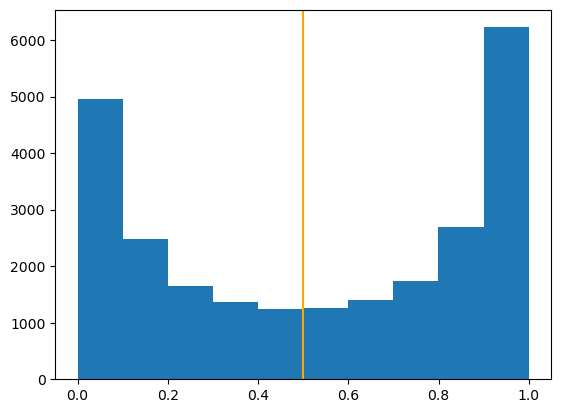

In [31]:
y_hat = model.predict(X_valid)
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [32]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'92.09'